# DeFactify 📰 - Iteration 3

This notebook is dedicated to developing a `Fake News Detection system`. To sum it up, if an article is "Fake", it is labeled by 0 and if it is considered "Real" - 1.

Let's begin by importing the libraries and checking their versions.

In [2]:
import nltk
import numpy
import joblib
import pandas
import sklearn
import seaborn

import matplotlib.pyplot as plt

from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier, RandomForestClassifier

print("Library versions:")
print("- nltk:", nltk.__version__)              # 3.9.1
print("- numpy:", numpy.__version__)            # 2.1.3
print("- joblib:", joblib.__version__)          # 1.4.2
print("- pandas:", pandas.__version__)          # 2.2.3
print("- sklearn:", sklearn.__version__)        # 1.6.1
print("- seaborn:", seaborn.__version__)        # 0.13.2

Library versions:
- nltk: 3.9.1
- numpy: 2.1.3
- joblib: 1.4.2
- pandas: 2.2.3
- sklearn: 1.6.1
- seaborn: 0.13.2


## Data provisioning 📦
Let's continue by loading all the scraped CSV files, containing two types of articles - "Fake" and "Real". 

The type of data I derived from each article is the following:
- Title 
- URL
- Source 
- Journalist(s) (if available)
- Published Date
- Content/Text of the article
- Category (Politics, Sports, etc.)
- Label: either "Fake" (0) or "Real" (1).

### Real News ✅ 
We will begin with <a href="https://www.bbc.com">BBC</a>: I collected 36-40 news from each day as indicated by the files' names. I was unable to find pagination on their website; all the content comes from the main page, so that is why there are 6 different ones.

BBC (British Broadcasting Corporation) is a pretty well-known website, which was voted as one of the most trustworthy news source online.

In [3]:
bbc1 = pandas.read_csv('scraper/dataset/bbc_23.03.25_real.csv')
bbc1.shape

(36, 8)

In [4]:
bbc2 = pandas.read_csv('scraper/dataset/bbc_24.03.25_real.csv')
bbc2.shape

(38, 8)

In [5]:
bbc3 = pandas.read_csv('scraper/dataset/bbc_27.03.25_real.csv')
bbc3.shape

(38, 8)

In [7]:
bbc4 = pandas.read_csv('scraper/dataset/bbc_31.03.25_real.csv')
bbc4.shape

(38, 8)

In [9]:
bbc5 = pandas.read_csv('scraper/dataset/bbc_06.04.25_real.csv')
bbc5.shape

(41, 8)

In [10]:
bbc6 = pandas.read_csv('scraper/dataset/bbc_07.04.25_real.csv')
bbc6.shape

(40, 8)

There are 2 other files from the websites: <a href="https://apnews.com/">AP News</a> and <a href="https://techcrunch.com/">TechCrunch</a>.

AP News provides unbiased, fact-based reporting, where as TechCrunch specializes in technology and startup news. Since I am behind in the category "Technology", I decided to gather news from there to even it.

In [11]:
ap = pandas.read_csv('scraper/dataset/apnews_real.csv', encoding='latin1')
ap.shape

(240, 8)

In [12]:
tech = pandas.read_csv('scraper/dataset/techcrunch_real.csv')
tech.shape

(135, 8)

I attempted to include The New York Times, The Washington Post and Bloomberg as well. Unfortunately, their articles are behind a paywall, preventing me from adding them. Additionally, Reuters denied me access due to restrictions.

### Fake News ❌
The websites I scarped with "Fake" news were: <a href="https://theonion.com/">The Onion</a>, <a href="https://spacexmania.com">SpaceXMania</a>, <a href="https://thepeoplesvoice.tv">The People's Voice</a> and <a href="https://www.theinteldrop.org">The Intel Drop</a>. Most websites spreading fake news have been flagged or removed, so my sources for recent news are somewhat limited.

Little information about each source I used:
- **The Onion** is an American digital media company and newspaper organization that publishes satirical articles on international, national and local news.
- The New York Times found that many stories from **SpaceXMania** were produced by generative AI. The Australian Associated Pressa also found that the site team used ChatGPT for writing content. Accused by academics of deceptively labeling clickbait content as satire.
- **The People's Voice** is an American fake news website. In 2017 was voted as the second-largest source of fake stories spread on Facebook by BuzzFeed News.
- **The Intel Drop** is a common Russian disinformation website.



In [13]:
onion = pandas.read_csv('scraper/dataset/the_onion_fake.csv')
onion.shape

(130, 8)

In [14]:
spacexmania = pandas.read_csv('scraper/dataset/spacexmania_fake.csv', encoding='latin1')
spacexmania.shape

(149, 8)

In [15]:
peoples_voice = pandas.read_csv('scraper/dataset/peoples_voice_fake.csv')
peoples_voice.shape

(100, 8)

In [16]:
intel_drop = pandas.read_csv('scraper/dataset/intel_drop_fake.csv', encoding='latin1')
intel_drop.shape

(102, 8)

### Combination of all CSV files 📥
Now let's combine all of the datasets into one, so we can work with it.

In [17]:
combined_dataset = pandas.concat([bbc1, bbc2, bbc3, bbc4, bbc5, bbc6, onion, spacexmania, peoples_voice, intel_drop, ap, tech])

In [18]:
print("Combined dataset shape (before cleaning):", combined_dataset.shape)

Combined dataset shape (before cleaning): (1087, 8)


## Sample the data 📃
Let's sample the data to check how it looks so far.

In [159]:
combined_dataset.sample(10)

,Title,URL,Source,Journalist(s),Published Date,Content,Category,Label
24,Idaho Becomes First U.S. State to Execute Pedo...,https://thepeoplesvoice.tv/idaho-becomes-first...,The People's Voice,Sean Adl-Tabatabai,4/4/2025,Idaho has become the first U.S. state to execu...,Crime,0
74,An AI doctoral candidate in California says th...,https://techcrunch.com/2025/04/21/an-ai-doctor...,TechCrunch,Kyle Wiggers,21-04-25,An AI doctoral student in California had their...,Technology,1
59,Dalai Lama Revises Claim Life Only Suffering W...,https://theonion.com/dalai-lama-revises-claim-...,The Onion,NaN,17-02-25,"DHARAMSHALA, INDIA—The Dalai Lama announced in...",Human Interest,0
9,Scientists Confirm a 99.9% Likelihood That Hum...,https://thepeoplesvoice.tv/scientists-confirm-...,The People's Voice,Sean Adl-Tabatabai,6/4/2025,"Scientists have dropped a bombshell, asserting...",Science,0
62,A Patristic Glimpse into Our Age: Antichrist a...,https://www.theinteldrop.org/2025/04/08/a-patr...,The Intel Drop,Matthew Raphael Johnson,8/4/2025,"By Matthew Raphael JohnsonJohnstown, PA By Mat...",Politics,0
36,China to retaliate with sanctions on US offici...,https://apnews.com/article/china-us-sanctions-...,AP News,Kanis Leung,21-04-25,HONG KONG (AP) â China will sanction United ...,World News,1
23,WEF Scientists Creating Lab-Grown Children Des...,https://thepeoplesvoice.tv/wef-scientists-crea...,The People's Voice,Baxter Dmitry,4/4/2025,"For years, the elite have been dropping hints,...",Science,0
10,"Over 30,000 Small Boat Migrants Have Arrived I...",https://thepeoplesvoice.tv/over-30000-small-bo...,The People's Voice,Niamh Harris,6/4/2025,"More than 30,000 migrants have arrived in Brit...",Politics,0
27,Bill Belichick Declares His Team Will Never Su...,https://spacexmania.com/bill-belichick-declare...,SpaceXMania,Alex Bruno,2-01-25,"Bill Belichick, the legendary head coach of th...",Sports,0
140,"Elon Musk Bans DreamWorks Animation from X, â...",https://spacexmania.com/elon-musk-bans-dreamwo...,SpaceXMania,Alex Bruno,22-10-24,"In his latest and most controversial move, Elo...",Politics,0


## Preprocessing 🛠️

Before training the algorithm, it is essential to ensure that the dataset is clean and free of any issues. 

This can be achieved by checking for any rows that contain missing data. If such rows exist, a decision should be made about whether to remove them.

In [160]:
combined_dataset.isnull().sum()

Title               0
URL                 0
Source              0
Journalist(s)     268
Published Date     19
Content            39
Category            4
Label               0
dtype: int64

To better understand the missing data, it is helpful to visualize it by a Heatmap.

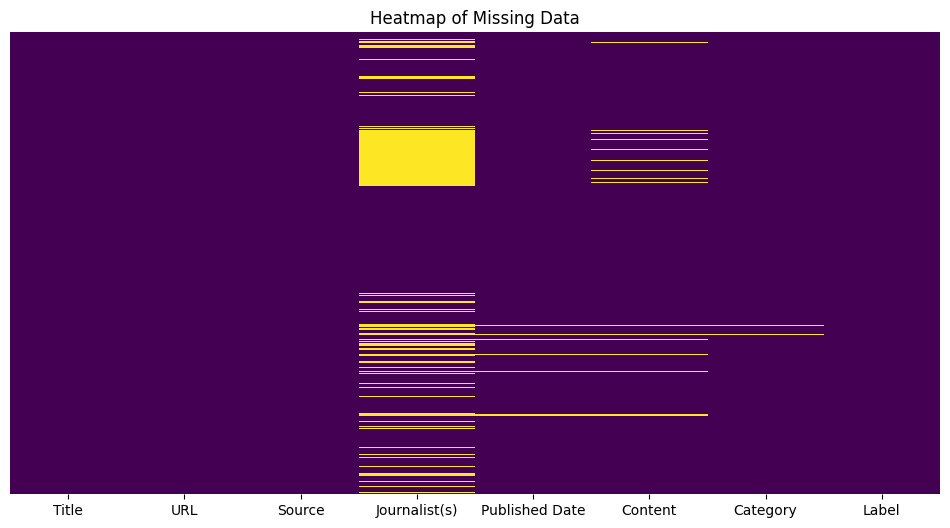

In [161]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(combined_dataset.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Data')
plt.show()

Let's compare it not just by the columns, but also by their label.

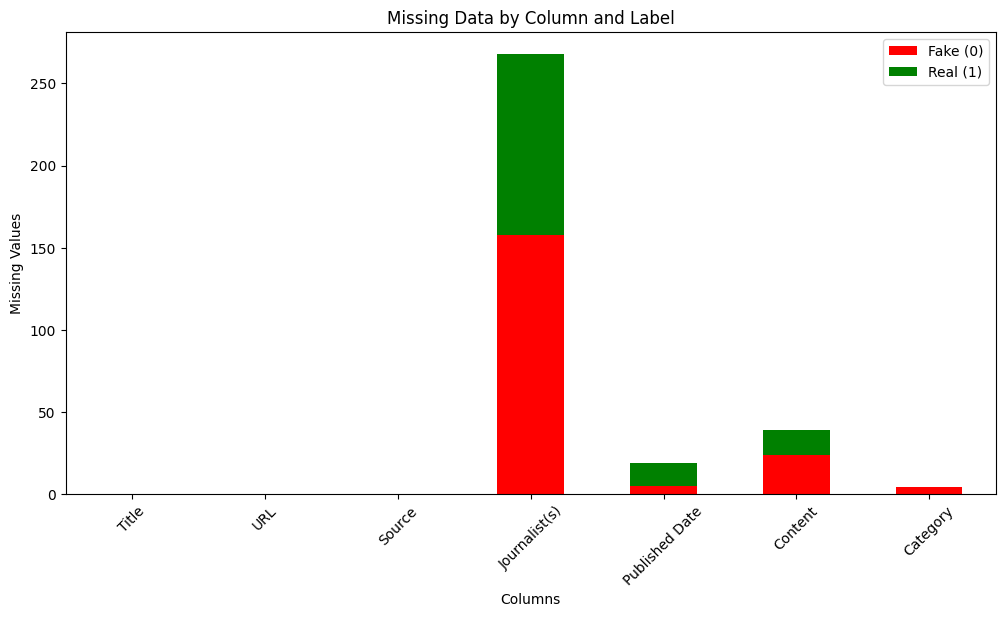

In [162]:
missing_by_label = combined_dataset.drop('Label', axis=1).groupby(combined_dataset['Label']).apply(lambda x: x.isnull().sum())

missing_by_label = missing_by_label.T

missing_by_label.plot(kind='bar', stacked=True, figsize=(12, 6), color=['red', 'green'])
plt.title('Missing Data by Column and Label')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.xticks(rotation=45)
plt.legend(['Fake (0)', 'Real (1)'])
plt.show()

As we can see vivdly the column with the most missing data is Journalist(s).

In this case, it is acceptable not to have any listed journalists, as it is common for fake news articles to lack authors. The absence of a publication date is also not a significant issue. However, the content is a key aspect we will analyse, so when either the content or the category is missing, we can discard those rows of data.

In [163]:
cleaned_dataset = combined_dataset.dropna(subset=['Content', 'Category'])

print("Combined dataset shape (after removing nulls):", cleaned_dataset.shape)

Combined dataset shape (after removing nulls): (1048, 8)


It would be helpful to check for duplicated news titles, as I have noticed that some titles reappear multiple times.

In [164]:
duplicate_titles = cleaned_dataset[cleaned_dataset.duplicated(subset=['Title'], keep=False)]

print(f"Number of duplicated titles: {duplicate_titles.shape[0]}")

Number of duplicated titles: 187


In [165]:
cleaned_dataset = cleaned_dataset.drop_duplicates(subset=['Title'], keep='first')

print("Combined dataset shape (after removing duplicates):", cleaned_dataset.shape)

Combined dataset shape (after removing duplicates): (940, 8)


I noticed different formatting of dates from English and American sources, so I will standardize them, even though it is not crucial.

In [166]:
cleaned_dataset['Published Date'] = pandas.to_datetime(cleaned_dataset['Published Date'], errors='coerce', dayfirst=True)
cleaned_dataset['Published Date'] = cleaned_dataset['Published Date'].dt.strftime('%d/%m/%Y')

cleaned_dataset.sample(10)

C:\Users\ivetk\AppData\Local\Temp\ipykernel_11964\880712371.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cleaned_dataset['Published Date'] = pandas.to_datetime(cleaned_dataset['Published Date'], errors='coerce', dayfirst=True)


,Title,URL,Source,Journalist(s),Published Date,Content,Category,Label
99,Rachel Maddow Follows Ellen DeGeneres to Engla...,https://spacexmania.com/rachel-maddow-follows-...,SpaceXMania,Alex Bruno,07/12/2024,In a move that has shocked her fans and thrill...,World News,0
167,An Asian elephant calf was born at Zurich Zoo ...,https://apnews.com/newsletter/ground-game/apri...,AP News,NaN,20/04/2025,ZURICH (AP) â A 19-year-old Asian elephant a...,Science,1
43,From Bogotá to the Battlefield: LatAm startups...,https://techcrunch.com/2025/04/18/from-bogota-...,TechCrunch,Isabelle Johannessen,18/04/2025,"For startups around the world, theTechCrunch S...",Technology,1
174,Archaeologists uncover the oldest known partia...,https://apnews.com/newsletter/ground-game/apri...,AP News,Christina Larson,12/03/2025,WASHINGTON (AP) â A fossil of a partial face...,Science,1
51,Trumpâs transactional approach to diplomacy ...,https://apnews.com/article/trump-transactional...,AP News,Aamer Madhani,09/03/2025,"WASHINGTON (AP) âDonald Trump, the real esta...",Politics,1
136,LeBron James Booted from U.S. Team After Harri...,https://spacexmania.com/lebron-james-booted-fr...,SpaceXMania,Alex Bruno,02/11/2024,In a move thatâs rocked the world of sports ...,Sports,0
57,Final day to submit your speaker application a...,https://techcrunch.com/2025/04/18/final-day-to...,TechCrunch,TechCrunch Events,18/04/2025,Today’s the day! The application to speak atTe...,Technology,1
5,Red Cross outraged over killing of eight medic...,https://www.bbc.com/news/articles/crkxm1rg6k1o,BBC,Jaroslav Lukiv,31/03/2025,The International Federation of Red Cross and ...,World News,1
54,Ukraine lying to its own people about the war ...,https://www.theinteldrop.org/2025/04/08/ukrain...,The Intel Drop,Ahmed Ade,08/04/2025,"Tuesday, April 8, 2025 Lucas Leiroz, member o...",Politics,0
30,Last shot at glory for 'legends'? Guardiola st...,https://www.bbc.com/sport/football/articles/c9...,BBC,Phil McNulty,30/03/2025,This video can not be played\r\n\r\nFA Cup hig...,Sports,1


In Iteration 1, I personally scraped the data, so I am familiar with most of the columns information. However, to ensure everything is accurate, I am conducting a final check to confirm that the data contains only 0s and 1s. Overall, the data appears to be evenly distributed between fake and real news.

In [167]:
group_info = cleaned_dataset.groupby(["Label"])["Label"].count()
group_info

Label
0    456
1    484
Name: Label, dtype: int64

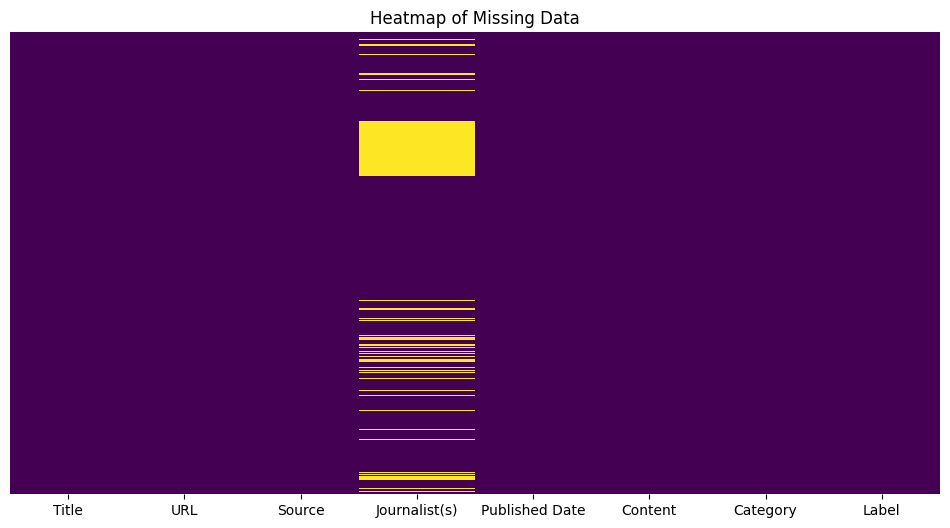

In [168]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(cleaned_dataset.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Data')
plt.show()

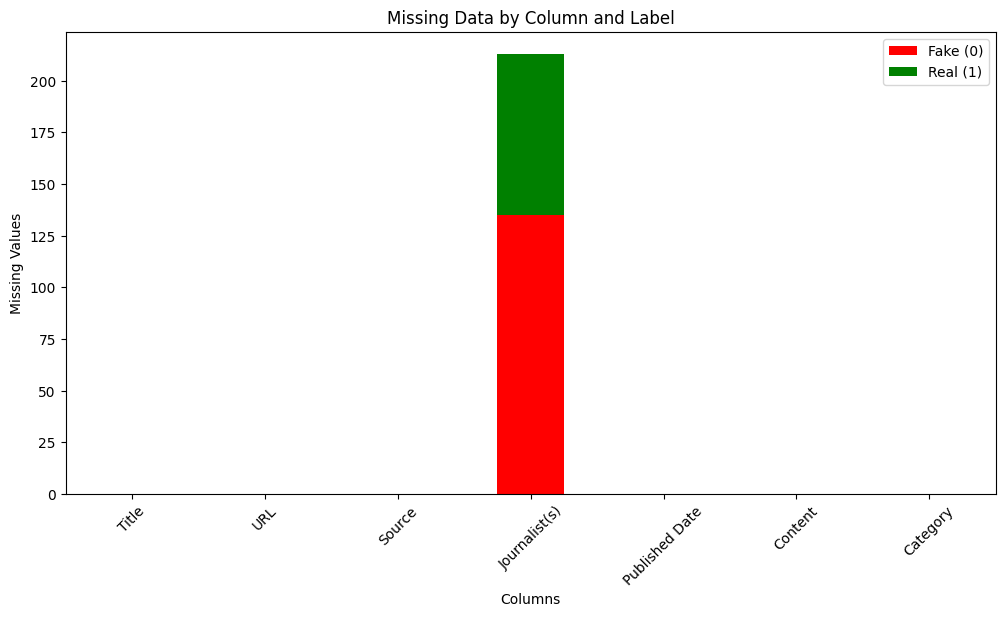

In [169]:
missing_by_label = cleaned_dataset.drop('Label', axis=1).groupby(cleaned_dataset['Label']).apply(lambda x: x.isnull().sum())

missing_by_label = missing_by_label.T

missing_by_label.plot(kind='bar', stacked=True, figsize=(12, 6), color=['red', 'green'])
plt.title('Missing Data by Column and Label')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.xticks(rotation=45)
plt.legend(['Fake (0)', 'Real (1)'])
plt.show()

When we cleaned the Content and Category columns, we also addressed issues with the published dates. This process removed some news articles that were likely not scraped properly, possibly due to improperly marked HTML tags. 

I believe that having no journalist listed is not a significant issue. In most cases, this implies that no article written by a listed journalist can be considered "fake". However, I will not take this into consideration for my training. I attempted to use it in Iteration 2, but it introduced bias. It assumed that if an article had a journalist, it was "real", and if not, it was "fake". Therefore, I will proceed without it.

In [170]:
print("The final dataset shape:", cleaned_dataset.shape)

The final dataset shape: (940, 8)


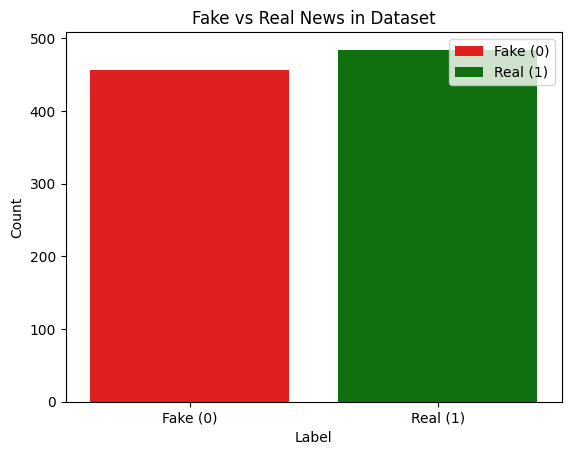

In [171]:
plt.figure()
seaborn.countplot(
    data=cleaned_dataset,
    x='Label',
    hue='Label', 
    palette={0: 'red', 1: 'green'}
)
plt.title('Fake vs Real News in Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.legend(['Fake (0)', 'Real (1)'])
plt.xticks(ticks=[0, 1], labels=['Fake (0)', 'Real (1)'])
plt.show()

Above is a comparison of the number of "Fake" and "Real" news articles in the dataset after cleaning. Overall, the counts are equal, so this should not introduce significant bias.

Since machine learning algorithms operate exclusively with numerical data and generate numerical outputs, the first step is to ensure that all the target variable is numeric. Therefore, we need to convert the Category column into numbers, but first let's visualise the categories and see how much we have from each.

In [172]:
category_counts = cleaned_dataset['Category'].value_counts()

category_table = category_counts.reset_index()
category_table.columns = ['Category', 'Count']

print(category_table)

         Category  Count
0        Politics    302
1   Entertainment    119
2          Sports    116
3      Technology    114
4      World News     80
5         Science     72
6         Economy     63
7  Human Interest     27
8           Crime     24
9     Environment     23


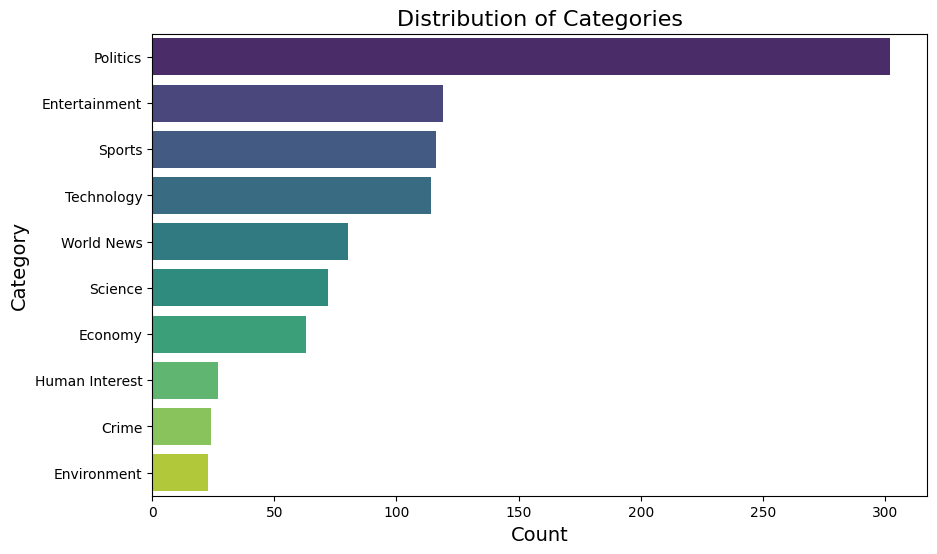

In [173]:
plt.figure(figsize=(10, 6))
seaborn.barplot(
    data=category_table,
    x='Count',
    y='Category',
    hue='Category', 
    palette='viridis'
)
plt.title('Distribution of Categories', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.show()

In [174]:
encoder = preprocessing.LabelEncoder()

cleaned_dataset.loc[:, "Category"] = encoder.fit_transform(cleaned_dataset["Category"])

cleaned_dataset.sample(10)

,Title,URL,Source,Journalist(s),Published Date,Content,Category,Label
11,South Korea court reinstates PM as acting leader,https://www.bbc.com/news/articles/c625jkyrx6do,BBC,Tessa Wong,24/03/2025,South Korea's constitutional court has dismiss...,5,1
2,US cares about human rights only to target adv...,https://www.theinteldrop.org/2025/04/10/us-car...,The Intel Drop,Annelle Sheline,10/04/2025,"Thursday, 10 April 2025 11:24 AM[ Last Update:...",5,0
89,OpenAI’s latest AI models have a new safeguard...,https://techcrunch.com/2025/04/16/openais-late...,TechCrunch,Maxwell Zeff,16/04/2025,OpenAI says that it deployed a new system to m...,8,1
70,Trump says gray skies for the White House East...,https://apnews.com/newsletter/ground-game/apri...,AP News,Darlene Superville,21/04/2025,WASHINGTON (AP) â PresidentDonald Trumpwelco...,5,1
31,Southampton relegated in record time with Spur...,https://www.bbc.com/sport/football/live/crkxdg...,BBC,Alex Brotherton,06/04/2025,Southampton have won just 10 points from their...,7,1
122,"WOKE Target to Close Stores in Red States, Rel...",https://spacexmania.com/woke-target-to-close-s...,SpaceXMania,Alex Bruno,12/11/2024,"In a dramatic post-election twist, Target has ...",1,0
20,"Jason Aldean Announces âOne Nation, One Flag...",https://spacexmania.com/jason-aldean-announces...,SpaceXMania,Alex Bruno,04/01/2025,"Jason Aldean, the chart-topping country music ...",2,0
110,Ecologists Call For Bee Extinction After Watch...,https://theonion.com/ecologists-call-for-bee-e...,The Onion,NaN,06/01/2025,"STANFORD, CA—In response to seeing what the po...",3,0
18,Hezbollah says it wonât hand over weapons wh...,https://apnews.com/article/lebanon-hezbollah-w...,AP News,NaN,19/04/2025,BEIRUT (AP) â The leader of Lebanonâs mili...,9,1
214,Chinaâs economy grew 5.4% in the first quart...,https://apnews.com/newsletter/ground-game/apri...,AP News,Elaine Kurtenbach,16/04/2025,BANGKOK (AP) â Chinaâs economy expanded at...,1,1


Let's categorize the articles based on the presence of an author. First, I want to analyze how frequently each journalist appears in the dataset.

In [175]:
print(cleaned_dataset['Journalist(s)'].value_counts())

Journalist(s)
Alex Bruno                       149
Niamh Harris                      43
Baxter Dmitry                     31
Sean Adl-Tabatabai                24
Kyle Wiggers                      14
                                ... 
Ng Han Guan                        1
Sean O'Kane                        1
Tage Kene-Okafor                   1
Mike Butcher                       1
Lorenzo Franceschi-Bicchierai      1
Name: count, Length: 323, dtype: int64


In [176]:
cleaned_dataset['Journalist(s)'] = cleaned_dataset['Journalist(s)'].notnull().astype(int)

print(cleaned_dataset['Journalist(s)'].value_counts())

Journalist(s)
1    727
0    213
Name: count, dtype: int64


In [177]:
aggregated_data = cleaned_dataset.groupby(['Journalist(s)', 'Label']).size().reset_index(name='Counts')

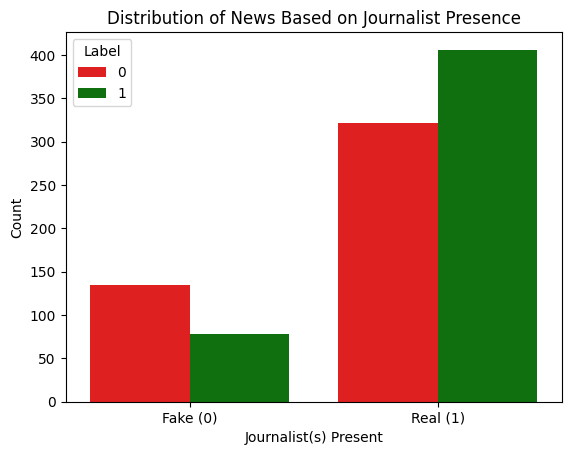

In [178]:
seaborn.barplot(
    data=aggregated_data,
    x='Journalist(s)',
    y='Counts',
    hue='Label',
    palette={0: 'red', 1: 'green'}
)
plt.title('Distribution of News Based on Journalist Presence')
plt.xlabel('Journalist(s) Present')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Fake (0)', 'Real (1)'])
plt.show()

As assumed, journalists' presence is strongly linked to "Real" news, while their absence is more often associated with "Fake" news.

### Stopwords 🛑
Stopwords are the most commonly used words in a language, such as "in", "on", "a", "an" and "the" in English. When determining if an article is fake, we often do not need those certain words. Let's first see them and then, remove them.

In [179]:
stemmer = PorterStemmer()

stop_words = set(stopwords.words('English'))

print(stopwords.words('English'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

### Stemming 🌱

Stemming is a technique that helps algorithms function more effectively. It reduces words to their root form. For instance, the words "programming", "programmer" and "programs" can all be reduced to the common word stem "program".

In [180]:
stemmer = PorterStemmer()

stop_words = set(stopwords.words('English'))

def preprocess_and_stem(text):
    # tokenize the text, convert to lowercase and remove punctuation
    tokens = word_tokenize(text.lower())
    # remove stopwords and apply stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word.isalnum() and word not in stop_words]

    return ' '.join(stemmed_tokens)

In [181]:
cleaned_dataset['Title'] = cleaned_dataset['Title'].astype(str).apply(preprocess_and_stem)
cleaned_dataset['Content'] = cleaned_dataset['Content'].astype(str).apply(preprocess_and_stem)

print(cleaned_dataset[['Title', 'Content']].head())

                                               Title  \
0     istanbul mayor arrest ahead select run erdogan   
1    kill gaza sinc israel offens began ministri say   
2              ferrari hamilton disqualifi chines gp   
3            life spent wait search row unclaim bodi   
5  us hope progress peac talk three kill russian ...   

                                             Content  
0  main rival turkey presid recep tayyip erdogan ...  
1  palestinian kill israel militari campaign gaza...  
2  lewi hamilton finish sixth chines grand prix s...  
3  saira baloch 15 step morgu first time heard ro...  
5  imogen jamesl report upcom peac talk ukrain wa...  


### Word Cloud ☁️
Let's visualise the most used words in both fake and real media, when it comes to the `Title` and `Content` of the news.

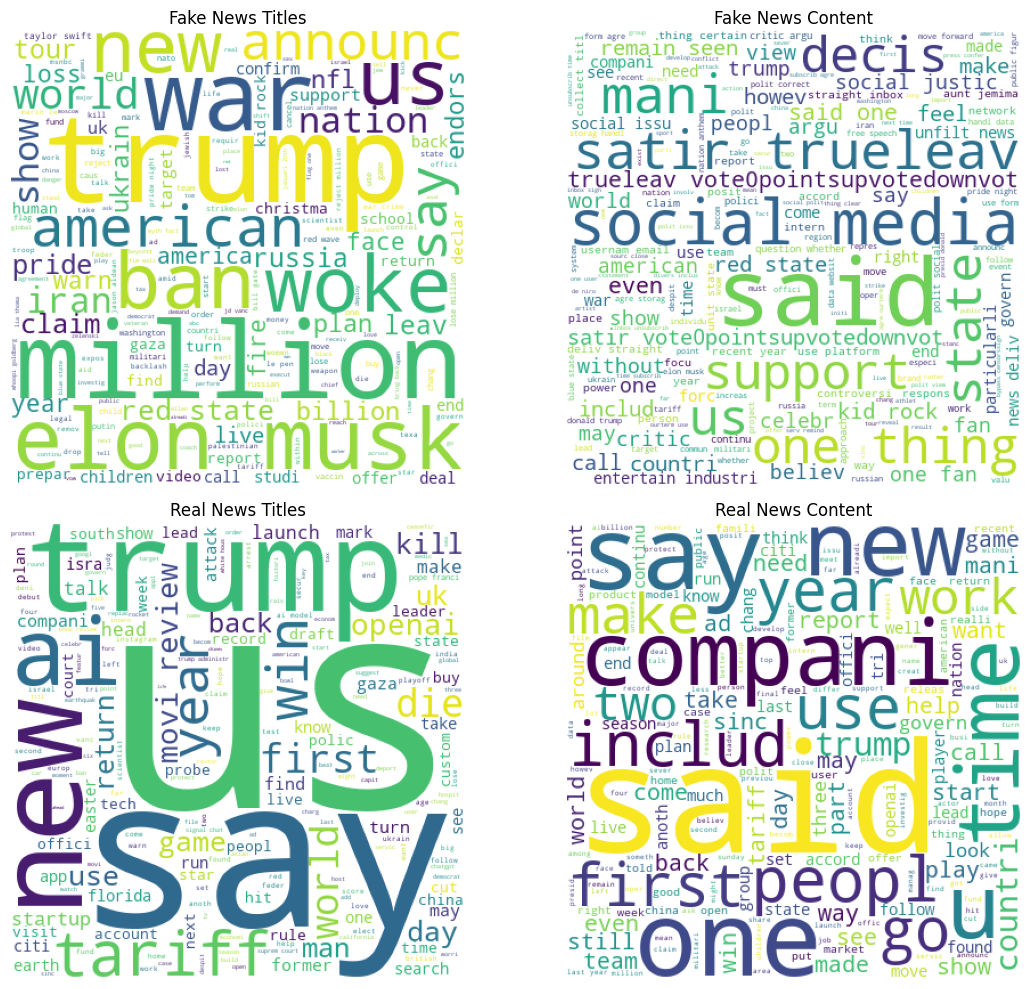

In [182]:
real_titles = ' '.join(cleaned_dataset[cleaned_dataset['Label'] == 1]['Title'])
fake_titles = ' '.join(cleaned_dataset[cleaned_dataset['Label'] == 0]['Title'])

real_content = ' '.join(cleaned_dataset[cleaned_dataset['Label'] == 1]['Content'])
fake_content = ' '.join(cleaned_dataset[cleaned_dataset['Label'] == 0]['Content'])

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# titles comparison
ax[0, 0].imshow(WordCloud(width=400, height=400, background_color='white').generate(fake_titles))
ax[0, 0].set_title("Fake News Titles")
ax[0, 0].axis('off')

ax[1, 0].imshow(WordCloud(width=400, height=400, background_color='white').generate(real_titles))
ax[1, 0].set_title("Real News Titles")
ax[1, 0].axis('off')

# content comparison
ax[1, 1].imshow(WordCloud(width=400, height=400, background_color='white').generate(real_content))
ax[1, 1].set_title("Real News Content")
ax[1, 1].axis('off')

ax[0, 1].imshow(WordCloud(width=400, height=400, background_color='white').generate(fake_content))
ax[0, 1].set_title("Fake News Content")
ax[0, 1].axis('off')

plt.tight_layout()
plt.show()

In comparison to Iteration 0, in Iteration 1 we can see more recent words that appear in current media, such as "tariff" and "Trump"; there is no mention of "Hillary Clinton" anymore. To summarize:

| **News**   | **Titles**                                                                                          | **Content**                                                                                          |
|-----------------|----------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------|
| **Fake**   | Big, dramatic words like "million", "war" and "woke" and names of famous people like "Trump", "Elon" and "Musk". | Focus on opinions, social media and words like "support", "satire" and "true". Less about facts, more about feelings or controversy. |
| **Real**   | Words about real events and places like "kill", "win", "Gaza", "Ukraine", "tariff" and "Trump". More factual and direct. | Focus on people, facts and explanations. Common words are "one", "people", "say", "year" and "country." More neutral and informative. |


### Converting the textual data to numerical data 🔁

TF-IDF (Term Frequency-Inverse Document Frequency) is used to convert textual data into numerical features, allowing machine learning models to process it. It assigns weights to words based on their frequency in a document and their rarity across the dataset, highlighting important terms. The `TfidfVectorizer` transforms the cleaned text data into a numerical array, which is used as the input features (X). The target labels (y), already numerical, represent the classification of each text as "Real" (1) or "Fake" (0).

In [183]:
vectorizer_title = TfidfVectorizer()
vectorizer_content = TfidfVectorizer()

X_title = vectorizer_title.fit_transform(cleaned_dataset['Title']).toarray()
X_content = vectorizer_content.fit_transform(cleaned_dataset['Content']).toarray()

print("Title TF-IDF shape:", X_title.shape)
print("Content TF-IDF shape:", X_content.shape)

Title TF-IDF shape: (940, 3135)
Content TF-IDF shape: (940, 22351)


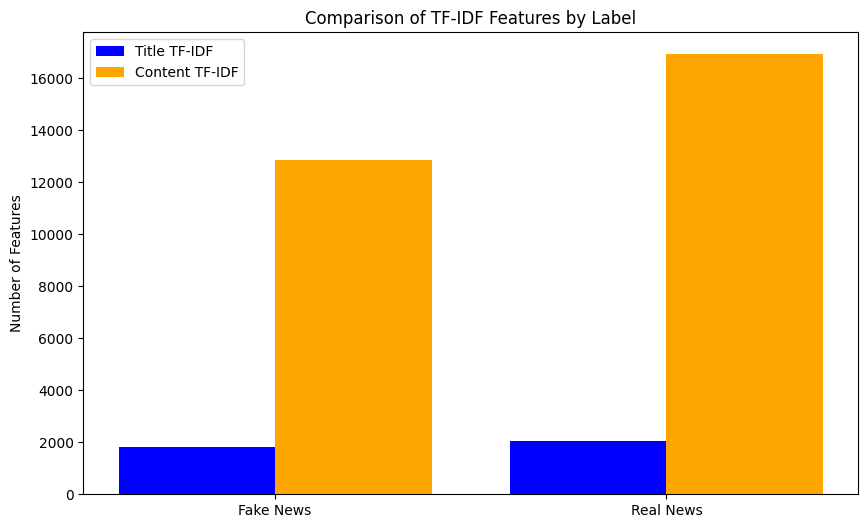

In [184]:
# split by label
fake_titles = cleaned_dataset[cleaned_dataset['Label'] == 0]['Title']
real_titles = cleaned_dataset[cleaned_dataset['Label'] == 1]['Title']

fake_contents = cleaned_dataset[cleaned_dataset['Label'] == 0]['Content']
real_contents = cleaned_dataset[cleaned_dataset['Label'] == 1]['Content']

# transform separately for fake and real data
fake_title_tfidf = vectorizer_title.fit_transform(fake_titles).shape[1]
real_title_tfidf = vectorizer_title.fit_transform(real_titles).shape[1]

fake_content_tfidf = vectorizer_content.fit_transform(fake_contents).shape[1]
real_content_tfidf = vectorizer_content.fit_transform(real_contents).shape[1]

# bar plot
labels = ['Fake News', 'Real News']
title_features = [fake_title_tfidf, real_title_tfidf]
content_features = [fake_content_tfidf, real_content_tfidf]

x = range(len(labels))

plt.figure(figsize=(10, 6))

# title features
plt.bar(x, title_features, width=0.4, label='Title TF-IDF', color='blue', align='center')
# content features
plt.bar([p + 0.4 for p in x], content_features, width=0.4, label='Content TF-IDF', color='orange', align='center')

plt.xticks([p + 0.2 for p in x], labels)
plt.title('Comparison of TF-IDF Features by Label')
plt.ylabel('Number of Features')
plt.legend()
plt.show()


| **Label**   | **Title TF-IDF Features**                                                                                          | **Content TF-IDF Features**                                                                                          |
|-----------------|----------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------|
| **Fake**   | ~1,900 | ~13,000 |
| **Real**   | ~2,000 | ~17,000 |

- **Content Richness:** Real News articles tend to be longer and more detailed, resulting in a greater diversity of terms and consequently, more TF-IDF features. Fake News articles, by contrast, may be shorter or use a more limited vocabulary.
- **Title Brevity:** Titles, regardless of label, yield far fewer features due to the imited word count.

### Combine the features 🥣
Combine the title and content into one feature matrix.

In [185]:
X = numpy.hstack((X_title, X_content))

### Target variable 🎯 
The target variable is obviously `Label`.

In [186]:
y = cleaned_dataset['Label']

### Splitting into train/test 🪓

We will use 80% of the data for training and the rest - 20% for testing.

In [1]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("There are in total", len(y), "observations, of which", len(X_train), "are now in the train set and", len(X_test), "in the test set.")

NameError: name 'train_test_split' is not defined

### Modelling 🧬
The test set will be used to calculate the model's accuracy, which indicates how well it performs. 

#### 1. Naive Bayes - Iteration 1
Naive Bayes is a probabilistic machine learning algorithm that is derived from Bayes' Theorem. It operates under the assumption that the features are conditionally independent, given the class label. This assumption simplifies calculations and enhances the model's computational efficiency. Despite its "naive" independence assumption, Naive Bayes frequently achieves good results in text classification tasks, such as spam detection and sentiment analysis. Also, it is computationally efficient, enabling quick training and predictions, even on large datasets.

In [188]:
clf_nb = MultinomialNB()

clf_nb.fit(X_train, y_train)

y_pred = clf_nb.predict(X_test)

In [189]:
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of Naive Bayes: {accuracy * 100:.2f}%")

Accuracy of Naive Bayes: 90.43%


In [190]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       107
           1       0.85      0.94      0.89        81

    accuracy                           0.90       188
   macro avg       0.90      0.91      0.90       188
weighted avg       0.91      0.90      0.90       188



The overall accuracy of the model is 90%. The F1-scores for both classes are close (0.91 vs. 0.89), indicating balanced performance with no severe bias toward either class.

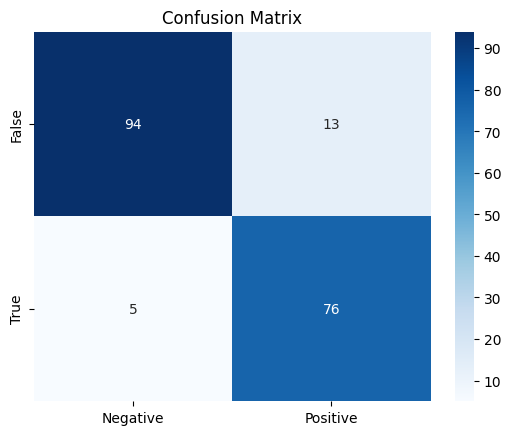

In [191]:
cm = confusion_matrix(y_test, y_pred)

seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix')
plt.show()

With Naive Bayes, the false positives outnumber the true negatives, which is not ideal. It is preferable to have fewer instances of "fake" news classified as truthful, as the opposite scenario is less detrimental. Classifying fake news as truthful (false positives) is harmful because it can spread misinformation, erode trust and amplify harmful content. On the other hand, mistakenly flagging truthful news as fake is less damaging since it encourages caution and further verification.

#### 2. Support Vector Machine (SVM)
It is a supervised learning algorithm that aims to find the optimal hyperplane that maximally separates classes in the feature space. It is particularly effective in high-dimensional spaces and is well-suited for both linear and non-linear classification tasks (using kernels). For text data, a linear kernel is typically sufficient and efficient.

**Con:** It can be slower to train on very large datasets (it took ~5 mins).

In [192]:
clf_svm = SVC(kernel='linear', probability=True, random_state=42)

clf_svm.fit(X_train, y_train)

y_pred_svm = clf_svm.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of SVC: {accuracy * 100}%")

Accuracy of SVC: 90.43%


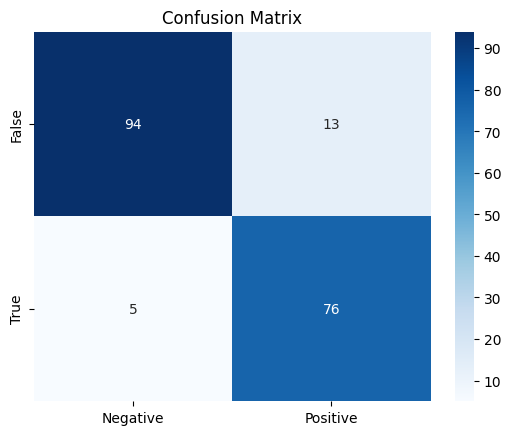

In [194]:
cm = confusion_matrix(y_test, y_pred)

seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix')
plt.show()

#### 3. Random Forest

Random Forest - A robust ensemble method that combines multiple decision trees.

In [195]:
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train[:, :-1], y_train)
y_pred_rf = clf_rf.predict(X_test[:, :-1])

KNN (Near Neighbors)

In [196]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

Stacking - Combine predictions from multiple models using a meta-classifier (e.g., Logistic Regression). This took too long - 22mins.

In [ ]:
estimators = [
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('naive_bayes', MultinomialNB()),
    ('svm', SVC(kernel='linear', probability=True)),
    ('rf', RandomForestClassifier(n_estimators=100))
]
stacked_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacked_model.fit(X_train[:, :-1], y_train)
y_pred_stacked = stacked_model.predict(X_test[:, :-1])

Clustering-Based Approaches - Clustering can reveal underlying structures in the data, which may help improve predictions.; K-Means Clustering for Feature Engineering - Cluster the data, then use the cluster assignments as an additional feature.

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_train[:, :-1])
X_train_clustered = numpy.hstack([X_train[:, :-1], kmeans_labels.reshape(-1, 1)])
X_test_clustered = numpy.hstack([X_test[:, :-1], kmeans.predict(X_test[:, :-1]).reshape(-1, 1)])

clf_clustered = RandomForestClassifier(n_estimators=100, random_state=42)
clf_clustered.fit(X_train_clustered, y_train)
y_pred_clustered = clf_clustered.predict(X_test_clustered)

Boosting Algorithms - AdaBoost

In [ ]:
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=42)
clf_ada.fit(X_train[:, :-1], y_train)
y_pred_ada = clf_ada.predict(X_test[:, :-1])

## Evaluation 🔬

This report evaluates the accuracy of recognising news as fake or real and assesses the model's performance.

In [ ]:
models = {
    "Naive Bayes": y_pred_nb,
    "K-NN": y_pred_knn,
    "SVM": y_pred_svm,
    "Random Forest": y_pred_rf,
    "Stacking": y_pred_stacked,
    "Clustered RF": y_pred_clustered,
    "AdaBoost": y_pred_ada
}

for model_name, y_pred in models.items():
    acc = accuracy_score(y_test, y_pred)
    print(f"{model_name}: Accuracy = {acc * 100:.2f}%")

Naive Bayes: Accuracy = 90.43%
K-NN: Accuracy = 83.51%
SVM: Accuracy = 93.62%
Random Forest: Accuracy = 92.55%
Stacking: Accuracy = 95.21%
Clustered RF: Accuracy = 90.96%
AdaBoost: Accuracy = 94.68%


It is important to consider the confusion matrix when evaluating a model's performance. The overall accuracy of the model is 89%. The F1-scores for both classes are close (0.92 vs. 0.87), indicating balanced performance with no severe bias toward either class.

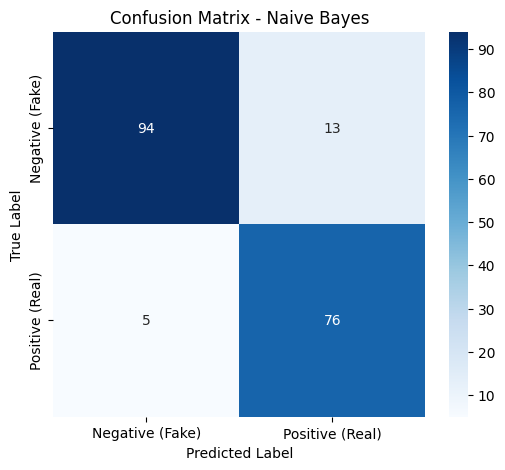

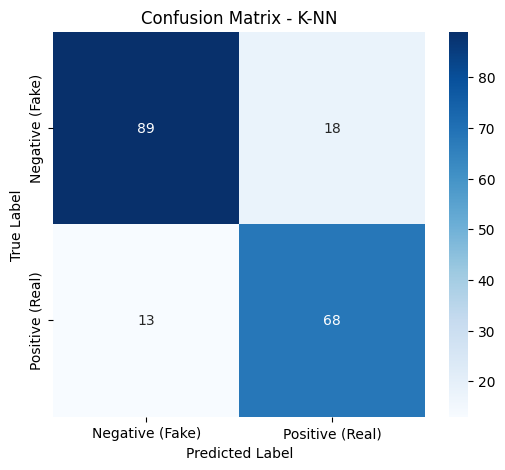

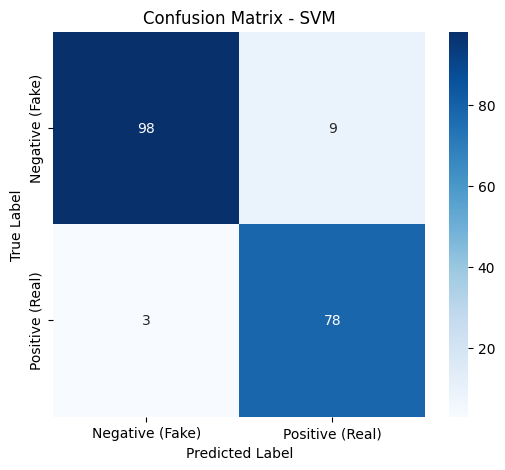

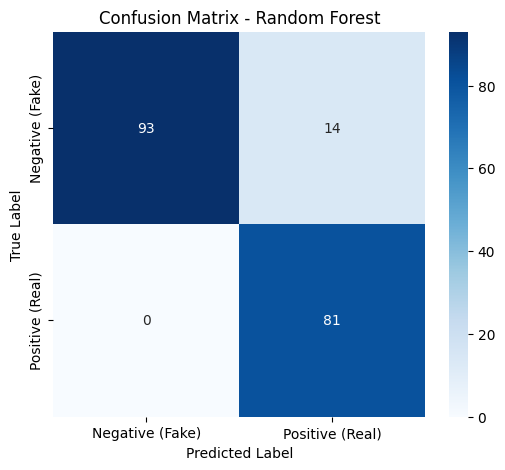

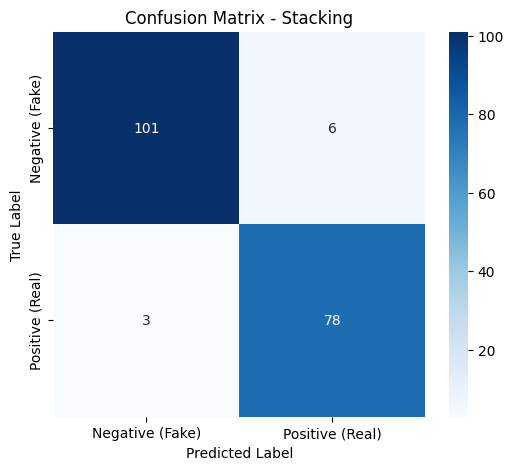

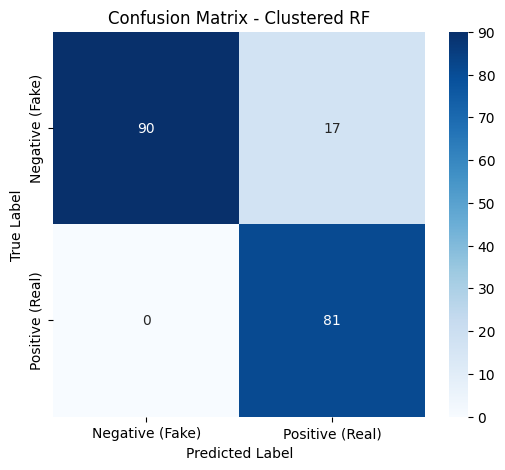

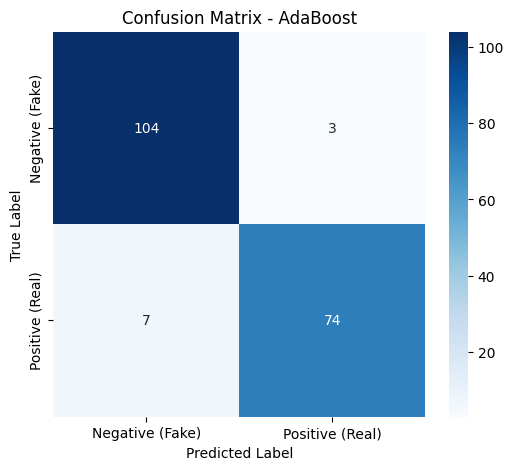

In [ ]:
models = {
    "Naive Bayes": y_pred_nb,
    "K-NN": y_pred_knn,
    "SVM": y_pred_svm,
    "Random Forest": y_pred_rf,
    "Stacking": y_pred_stacked,
    "Clustered RF": y_pred_clustered,
    "AdaBoost": y_pred_ada
}

for model_name, y_pred in models.items():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    seaborn.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=['Negative (Fake)', 'Positive (Real)'], 
        yticklabels=['Negative (Fake)', 'Positive (Real)']
    )
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

This time, the false positives are fewer than the true negatives, which has been the desired goal since Iteration 0. In my opinion, it is better to classify more true news as fake than to classify fake news as truthful.

## Website 🌐

In [ ]:
joblib.dump(clf_nb, 'website/models/naive_bayes_model.pkl')

['website/models/naive_bayes_model.pkl']

In [ ]:
joblib.dump(vectorizer_title, 'website/models/vectorizer_title.pkl')
joblib.dump(vectorizer_content, 'website/models/vectorizer_content.pkl')

['website/models/vectorizer_content.pkl']

In [ ]:
joblib.dump(clf_tree, 'website/models/decision_tree_model.pkl')

['website/models/decision_tree_model.pkl']